In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 20, 4
rcParams['figure.dpi'] = 500
rcParams.update({'font.size': 16})

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
class RealNVP(nn.Module):
    """
    This code is based on the github reposetory: https://github.com/senya-ashukha/real-nvp-pytorch.
    
    A simple implementation for RealNVP.
    inputs:
     - nets, a neural netwerk that learns the sacaling for each coupling layer.
     - nett, a neural netwerk that learns the translating for each coupling layer.
     - mask, this determines which part of the data undergoes the afine projection and which is used as inputs for nett and nets.
     - prior, the prior which is used to approximate each label.
     - lr, learning rate for approximating the prior distribution.
    """
    def __init__(self, nets, nett, mask, prior, lr=0.1):
        super().__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        self._lambda = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(True),
            nn.Linear(8, 8),
            nn.ReLU(True),
            nn.Linear(8, 4),
            nn.Softplus(),
        )     
        
        # nn.Parameters has to be used to prevent memory leaks.
        with torch.no_grad():
            self.lr = lr
            self.mu0 = nn.Parameter(torch.zeros(2), requires_grad=False) 
            self.mu1 = nn.Parameter(torch.zeros(2), requires_grad=False)
            self.s0 = nn.Parameter(torch.eye(2), requires_grad=False)
            self.s1 = nn.Parameter(torch.eye(2), requires_grad=False)
    
    def f(self, x, u):
        """
        forward function, which is constructed using the RealNVP implementation and the objective function from iflow,
        from the paper: Identifying through Flows for Recovering Latent Representations, ICLR2020.
        github: https://github.com/MathsXDC/iFlow
        """
        log_det_J = x.new_zeros(x.shape[0])
        for translate, scale, mask in zip(self.t, self.s, self.mask):
            x1 = y1 = x * mask
            x2 = x * (1 - mask)
            s = scale(x1) * (1 - mask)
            t = translate(x1) * (1 - mask)
            y2 = x2 * torch.exp(s) + t
            x = y1 + y2
            log_det_J += s.sum(dim=1)
        z = x
        
        T = torch.cat((z*z, z), axis=1).view(-1, 2, 2)

        nat_params = self._lambda(u) 
        nat_params = nat_params.reshape(-1, 2, 2)
        self.mask2 = torch.ones((x.shape[0], 2, 2))
        self.mask2[:, :, 0] *= -1.0
        
        nat_params = nat_params * self.mask2
        
        return z, T, nat_params, log_det_J
    
    def g(self, y):
        """
        Reverse function of the forward.
        """
        for translate, scale, mask in zip(reversed(self.t), reversed(self.s), reversed(self.mask)):
            y1 = x1 = y * mask
            y2 = y * (1 - mask)
            s = scale(y1) * (1 - mask)
            t = translate(y1) * (1 - mask)
            x2 = (y2 - t) * torch.exp(-s)
            y = x1 + x2
        x = y
        return x
    
    def log_prob(self, x, u):
        """
        log probability of the objective function used in iflow. 
        """
        z, T, nat_params, logp = self.f(x, u)    
        return self.free_energy_bound(T, nat_params) - logp.mean(), z
    
    def free_energy_bound(self, T, nat_params):
        """
        This function is copied from the iflow code, which calculates the loss except the log jacobian.
        """
        B = T.size(0)
        
        sum_traces = 0.0
        for i in range(B):
            sum_traces += (torch.trace(nat_params[i].mm(T[i]))) 
        avg_traces = sum_traces / B
       
        log_normalizer = -.5 * torch.sum(torch.log(torch.abs(nat_params[:, :, 0]))) / B
        nat_params_sqr = torch.pow(nat_params[:, :, 1], 2)
        log_normalizer -= (torch.sum(nat_params_sqr / (4*nat_params[:, :, 0])) / B)

        return log_normalizer - avg_traces 
    
    def train_latent_space(self, z, label):
        """
        If the models is used for sampling the latent space must be saved.
        This is done in this function where for each label a prior distribution is used to approximate the latent space for that label.
        """
        with torch.no_grad():
            label = label.bool()
            m0 = torch.mean(z[label], 0)
            m1 = torch.mean(z[~label], 0)
            self.mu0.copy_((1 - self.lr) * self.mu0 + self.lr * m0)
            self.mu1.copy_((1 - self.lr) * self.mu1 + self.lr * m1)
            z0 = z[label] - m0
            z1 = z[~label] - m1
            self.s0.copy_((1 - self.lr) * self.s0 + self.lr * (z0.T @ z0 / (z0.shape[0] - 1)))
            self.s1.copy_((1 - self.lr) * self.s1 + self.lr * (z1.T @ z1 / (z1.shape[0] - 1)))
    
    def sample(self, batchSize):
        """
        Per label batchsize number of points are generated using the appriximate latent space.
        Before using sample train_latent_space must be used during training.
        
        returns latent and original space for each label.
        """
        y0 = self.prior(self.mu0, self.s0).sample((batchSize, 1))
        x0 = self.g(y0)
        y1 = self.prior(self.mu1, self.s1).sample((batchSize, 1))
        x1 = self.g(y1)
        return x0, x1, y0, y1

In [26]:
hdim = 32
nets = lambda: nn.Sequential(nn.Linear(2, hdim), nn.LeakyReLU(), nn.Linear(hdim, hdim), nn.LeakyReLU(), nn.Linear(hdim, 2), nn.Sigmoid())
"""
nets (net scale)
nets nodes: 2 input nodes, hdim hidden nodes, hdim hidden nodes, 2 output nodes
activations are Relu and last Tanh.
"""
nett = lambda: nn.Sequential(nn.Linear(2, hdim), nn.LeakyReLU(), nn.Linear(hdim, hdim), nn.LeakyReLU(), nn.Linear(hdim, 2))
"""
nett (net translation)
nett nodes: 2 input nodes, hdim hidden nodes, hdim hidden nodes, 2 output nodes
activations are Relu and no end activation. 
"""
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) #6 coupling layers alternating
prior = distributions.MultivariateNormal #2D gaussian prior
flow = RealNVP(nets, nett, masks, prior)

In [27]:
"""
The model is trained by first 10000 iterations with lr 1e-4 and then 5000 iterations using 1e-5 as learning rate.
"""
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(10001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    u = torch.zeros((64,2))
    label = torch.from_numpy(label)
    u[:,0] = label
    u[:,1] = 1-label
    loss, z = flow.log_prob(x, u)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    flow.train_latent_space(z, label)
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-5)
for t in range(10001, 15001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    u = torch.zeros((64,2))
    label = torch.from_numpy(label)
    u[:,0] = label
    u[:,1] = 1-label
    loss, z = flow.log_prob(x, u)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    flow.train_latent_space(z, label)
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 18.329
iter 500: loss = 1.884
iter 1000: loss = 0.749
iter 1500: loss = 0.340
iter 2000: loss = 0.058
iter 2500: loss = -0.141
iter 3000: loss = -0.218
iter 3500: loss = -0.215
iter 4000: loss = -0.475
iter 4500: loss = -0.636
iter 5000: loss = -0.518
iter 5500: loss = -0.717
iter 6000: loss = -0.872
iter 6500: loss = -0.947
iter 7000: loss = -1.068
iter 7500: loss = -1.357
iter 8000: loss = -1.280
iter 8500: loss = -1.256
iter 9000: loss = -1.255
iter 9500: loss = -1.304
iter 10000: loss = -1.354
iter 10500: loss = -1.554
iter 11000: loss = -1.403
iter 11500: loss = -1.548
iter 12000: loss = -1.329
iter 12500: loss = -1.493
iter 13000: loss = -1.346
iter 13500: loss = -1.299
iter 14000: loss = -1.409
iter 14500: loss = -1.529
iter 15000: loss = -1.461


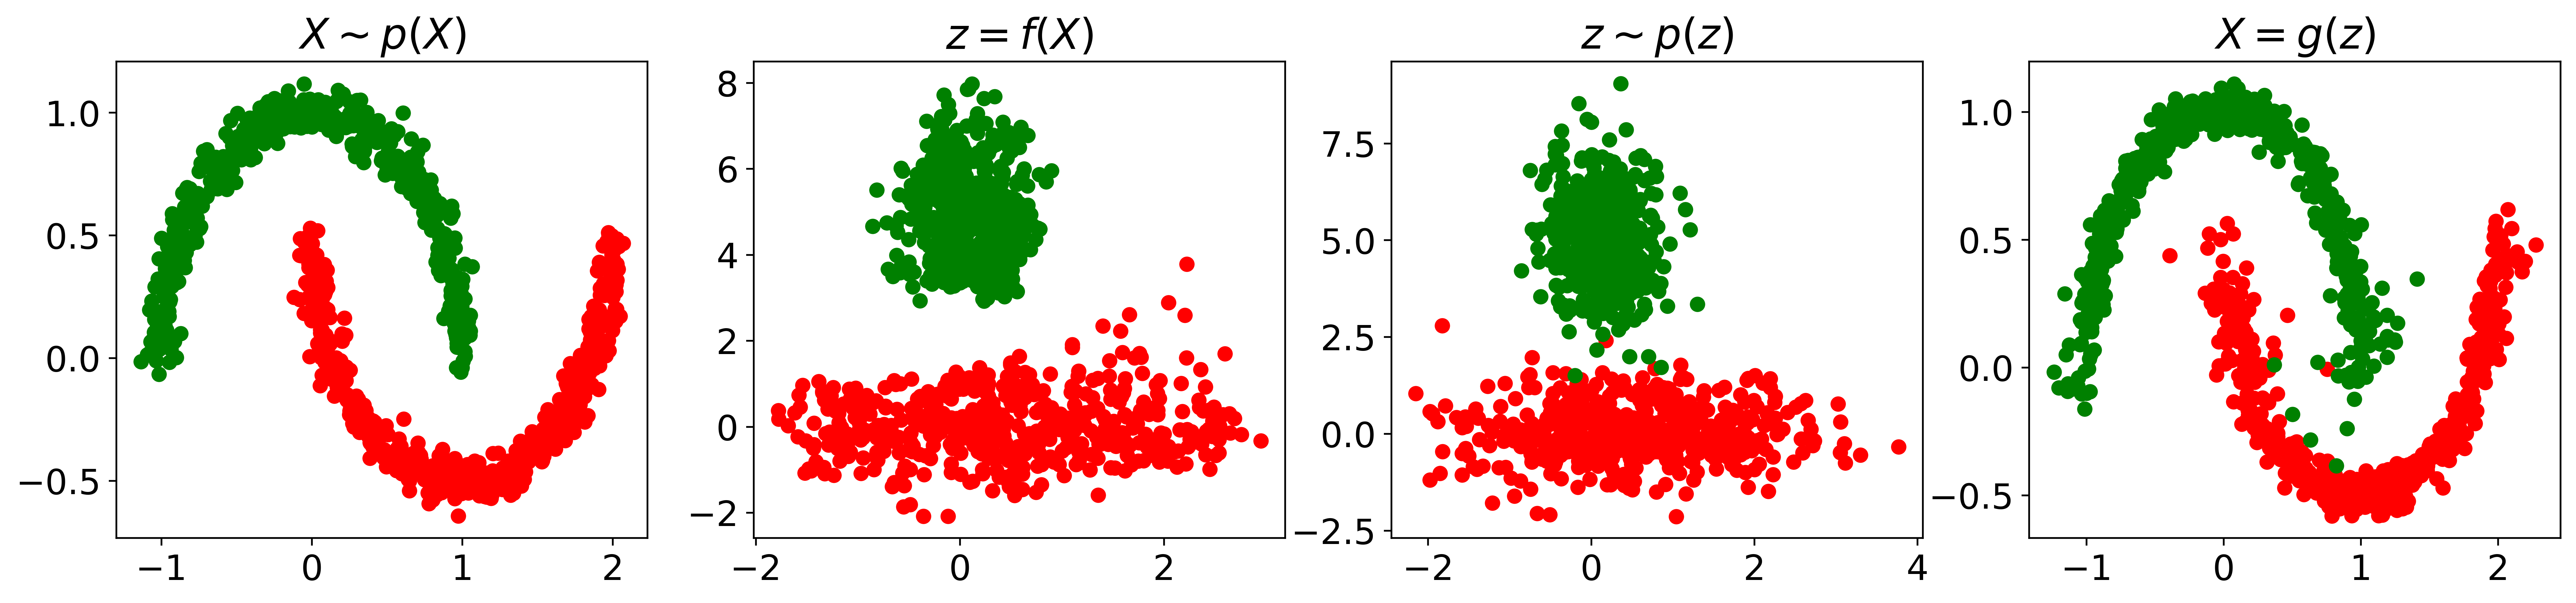

In [28]:
rcParams['figure.figsize'] = 20, 4

# Generate synthetic data for the plots.
noisy_moons, label = datasets.make_moons(n_samples=1000, noise=.05)
u = torch.zeros((1000,2))
l = torch.from_numpy(label)
u[:,0] = l
u[:,1] = 1-l
label = label.astype(bool)

# plot the original data X
plt.subplot(141)
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
y = y.astype(bool)
plt.scatter(x[y, 0], x[y, 1], c='r')
plt.scatter(x[~y, 0], x[~y, 1], c='g')
plt.title(r'$X \sim p(X)$')

# plot the latent space after encoding the data using model.f(x, u)
z = flow.f(torch.from_numpy(noisy_moons.astype(np.float32)), u)[0].detach().numpy()
plt.subplot(142)
plt.scatter(z[label, 0], z[label, 1], c='r')
plt.scatter(z[~label, 0], z[~label, 1], c='g')
plt.title(r'$z = f(X)$')

# plot generated latent space points using the appriximate prior distributions  
plt.subplot(143)
x0, x1, y0, y1 = flow.sample(500)
x0 = x0.detach().numpy()
x1 = x1.detach().numpy()
y0 = y0.detach().numpy()
y1 = y1.detach().numpy()
plt.scatter(y0[:, 0, 0], y0[:, 0, 1], c='r')
plt.scatter(y1[:, 0, 0], y1[:, 0, 1], c='g')
plt.title(r'$z \sim p(z)$')

# plot the decoded generated latent space points in the orginal space.
plt.subplot(144)
plt.scatter(x0[:, 0, 0], x0[:, 0, 1], c='r')
plt.scatter(x1[:, 0, 0], x1[:, 0, 1], c='g')
plt.title(r'$X = g(z)$')
plt.show()

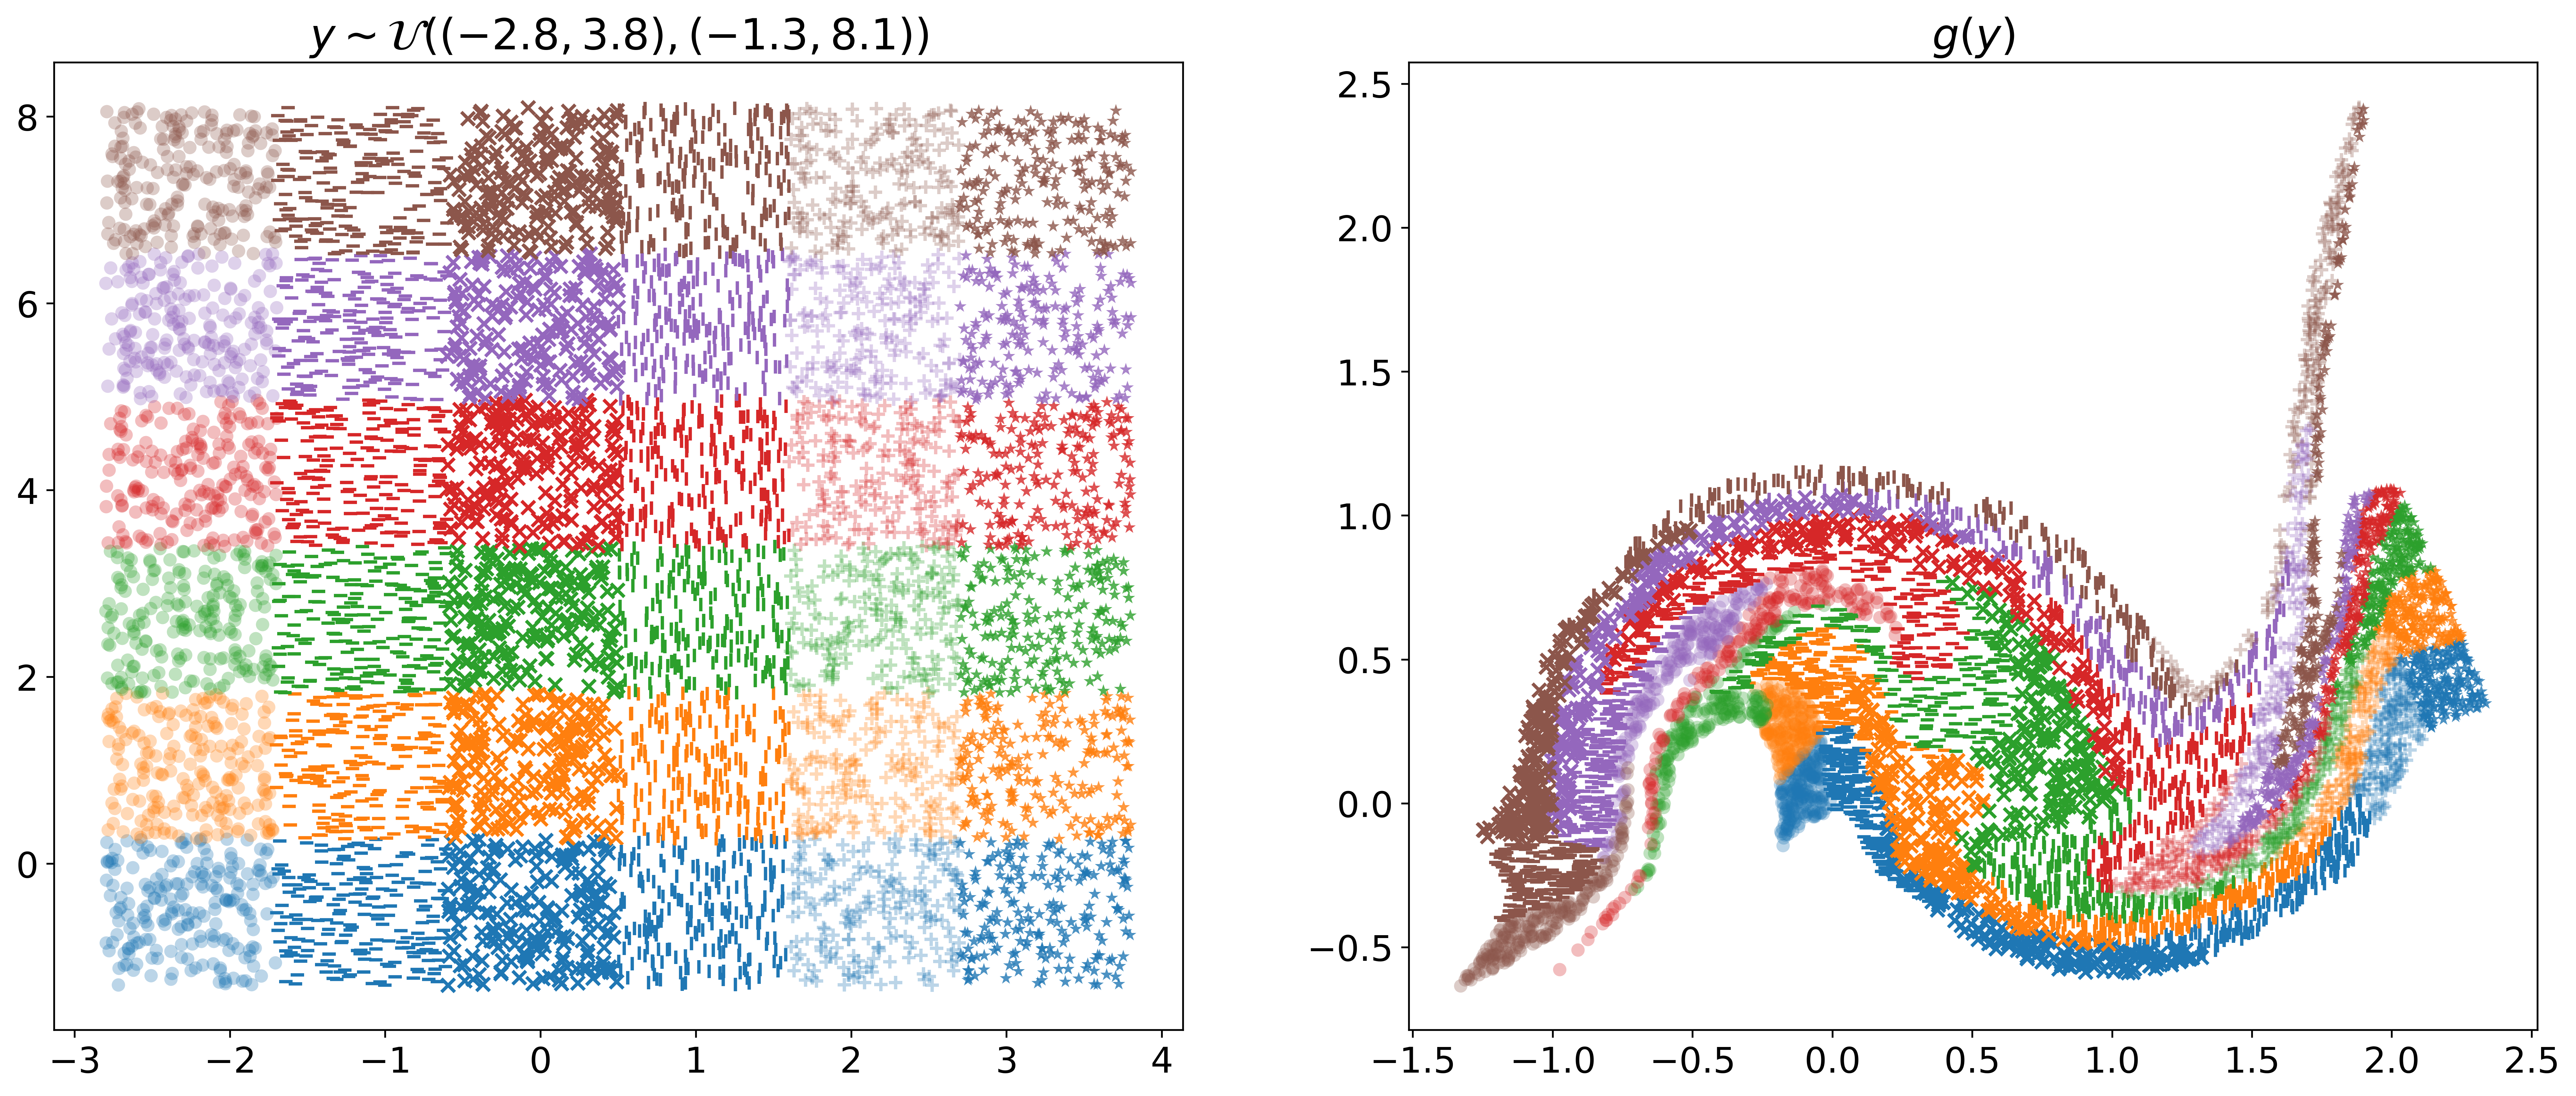

In [29]:
rcParams['figure.figsize'] = 20, 8

# Calculating the spanned latent space by both Gaussians
x0min = flow.mu0[0] - 2.5 * flow.s0[0,0]
x0max = flow.mu0[0] + 2.5 * flow.s0[0,0]
y0min = flow.mu0[1] - 2.5 * flow.s0[1,1]
y0max = flow.mu0[1] + 2.5 * flow.s0[1,1]
x1min = flow.mu1[0] - 2.5 * flow.s1[0,0]
x1max = flow.mu1[0] + 2.5 * flow.s1[0,0]
y1min = flow.mu1[1] - 2.5 * flow.s1[1,1]
y1max = flow.mu1[1] + 2.5 * flow.s1[1,1]

# Make a 6x6 grid of the latent space and sample n points unifrom in each quadrant. 
n = 200
xrange = (round(min(x0min, x1min).item(), 1), round(max(x0max, x1max).item(), 1))
yrange = (round(min(y0min, y1min).item(), 1), round(max(y0max, y1max).item(), 1))
cycle = 6
markers = ['o', '_', 'x', '|', '+', '*']
alphas = [0.3, 1, 1, 1, 0.3, 0.8] 
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
block = []
xstep = (xrange[1] - xrange[0]) / cycle
ystep = (yrange[1] - yrange[0]) / cycle
for i in np.linspace(xrange[0], xrange[1]-xstep, cycle):
    for j in np.linspace(yrange[0], yrange[1]-ystep, cycle):
        block.append((torch.FloatTensor(n).uniform_(i, i+xstep),
                      torch.FloatTensor(n).uniform_(j, j+ystep))) 


# plot each quadrant in a seperate color in y direction and seprate symbol in x direction in the latent space. 
plt.subplot(121)
plt.title(r'$y \sim \mathcal{U}('+f'{xrange}'+', '+f'{yrange}'+')$')
i = 0
for x, y in block:
    plt.scatter(x, y, linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
    
# plot each quadrant in a seperate color in y direction and seprate symbol in x direction in the original space. 
plt.subplot(122)
plt.title(r'$g(y)$')
i = 0
for x, y in block:
    z = flow.g(torch.stack((x, y)).T).detach().numpy()
    plt.scatter(z[:,0], z[:,1], linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
plt.show()